# SMS Spam Detection Using Machine Learning


---


## Practice Module: Pattern Recognition Systems (PRS)

## Group: 18

## Members:

Lim Jun Ming, A0231523U

Mediana, A0231458E

Yeong Wee Ping, A0231533R

# Deep Learning Neural Network

# 0. File Path & Library Setup

In [3]:
# Load All Necessary Packages

import os
# from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import sklearn as sk
import random

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

from IPython.display import clear_output

seed = 18
random.seed(seed)

print("Versions of key libraries")
print("-------------------------")
print("pandas:      ", pd.__version__)
print("numpy:       ", np.__version__)
print("tensorflow:  ", tf.__version__)
print("sklearn:     ", sk.__version__)

Versions of key libraries
-------------------------
pandas:       1.3.3
numpy:        1.19.5
tensorflow:   2.6.0
sklearn:      1.0


In [87]:
# # Mounting to Google Drive
# drive.mount('/content/gdrive')

# # Change Working Directory
# os.chdir('/content/gdrive/My Drive/iss/prs_pm/training')

print('Working Directory: ')
os.getcwd()

Working Directory: 


'D:\\Personal\\Education\\NUS-ISS Mtech IS\\Course Materials\\2. Pattern Recognition Systems (PRS)\\0. PRS-PM_Practice Module\\Source Code\\Spam Text Model Training'

# 1. Load and Combine Raw Data

## Pretrained GloVe Word Embeddings

In [4]:
# X feature maps (GloVe)

# pre-trained word embeddings (30x50 feature space per sms)
X_glove30x50_file = open('2. Feature Map/X_vec_30x50.pickle', 'rb')
X_glove30x50_pickle = pickle.load(X_glove30x50_file)
X_train_vec_30x50 = X_glove30x50_pickle[0]
X_val_vec_30x50 = X_glove30x50_pickle[1]
X_test_vec_30x50 = X_glove30x50_pickle[2]
X_glove30x50_file.close()
print('X Feature Map - Pretrained GloVe Embeddings (30x50):')
print('Dimension of X_train : ' + str(X_train_vec_30x50.shape))
print('Dimension of X_val   : ' + str(X_val_vec_30x50.shape))
print('Dimension of X_test  : ' + str(X_test_vec_30x50.shape))
print('----------------------------------------------------\n')


X Feature Map - Pretrained GloVe Embeddings (30x50):
Dimension of X_train : (4085, 30, 50)
Dimension of X_val   : (876, 30, 50)
Dimension of X_test  : (876, 30, 50)
----------------------------------------------------



## Word Sequence Indexing for Word Embeddings Training

In [5]:
# X feature maps (Word Sequence Indexing)

# Word Sequencing Index (First 30 words)
X_30idx_file = open('2. Feature Map/X_30idx.pickle', 'rb')
X_30idx_pickle = pickle.load(X_30idx_file)
X_train_30idx = X_30idx_pickle[0]
X_val_30idx = X_30idx_pickle[1]
X_test_30idx = X_30idx_pickle[2]
X_30idx_file.close()
print('Word Sequencing Index (30 Words):')
print('Dimension of X_train : ' + str(X_train_30idx.shape))
print('Dimension of X_val   : ' + str(X_val_30idx.shape))
print('Dimension of X_test  : ' + str(X_test_30idx.shape))
print('----------------------------------\n')

Word Sequencing Index (30 Words):
Dimension of X_train : (4085, 30)
Dimension of X_val   : (876, 30)
Dimension of X_test  : (876, 30)
----------------------------------



## y Labels

In [6]:
# y Labels
y_label_file = open('2. Feature Map/y_label.pickle', 'rb')
y_label_pickle = pickle.load(y_label_file)
y_train = y_label_pickle[0]
y_val = y_label_pickle[1]
y_test = y_label_pickle[2]
y_label_file.close()
print('Label Dataset:')
print('Dimension of y_train : ' + str(y_train.shape))
print('Dimension of y_val   : ' + str(y_val.shape))
print('Dimension of y_test  : ' + str(y_test.shape))


Label Dataset:
Dimension of y_train : (4085,)
Dimension of y_val   : (876,)
Dimension of y_test  : (876,)


## Tokenizer

In [8]:
# Loading Word Tokenizer
tk_file = open('3. parameters/bowtokenizer.pickle', 'rb')
tk = pickle.load(tk_file)
tk_file.close()
tk_size = len(tk.word_index)

print('Word Tokenizer:')
print('Vocabulary Size : ' + str(tk_size))

Word Tokenizer:
Vocabulary Size : 6389


# 2. Networks Using Pre-Trained GloVe Embeddings

## i. Dense Classifier (GloVE)

### i.1 Model Architecture

In [ ]:
# Initilization
glove_emb_shape = X_train_vec_30x50[0].shape # Word Embeddings shape per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.00015)
modelname       = 'GloVe_Dense_30x50'

# Define Model
def glove_dense_30x50():
    ipt = Input(shape=glove_emb_shape)
    x = Flatten()(ipt)
    # x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.3))(x)
    # x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.3))(x)
    x = Dropout(0.3)(x)
    # x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    # x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
gd30x50     = glove_dense_30x50()
gd30x50_go  = glove_dense_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     

# Model Setup Summary
gd30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

### i.2 Train Model

In [93]:
# Train Model
num_epoch = 30
batchsize = 50

gd30x50_fit = gd30x50.fit(x=X_train_vec_30x50, y=y_train, validation_data=(X_val_vec_30x50, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/30
82/82 [==============================] - 1s 7ms/step - loss: 170.0626 - accuracy: 0.7988 - val_loss: 116.5025 - val_accuracy: 0.8390
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 83.2570 - accuracy: 0.8406 - val_loss: 55.9293 - val_accuracy: 0.8482
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 39.4020 - accuracy: 0.8815 - val_loss: 26.0227 - val_accuracy: 0.9087
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 18.2126 - accuracy: 0.9327 - val_loss: 12.0065 - val_accuracy: 0.9395
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 8.5267 - accuracy: 0.9506 - val_loss: 5.8135 - val_accuracy: 0.9498
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 4.3309 - accuracy: 0.9606 - val_loss: 3.1959 - val_accuracy: 0.9509
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 2.5641 - accuracy: 0.9647 - val_loss: 2.0984 - val_accuracy: 0.9543
Epoch 8/30

### i.3 Save Model

In [94]:
# Load Weights of Trained Model
gd30x50_go.load_weights(weightfilepath)
gd30x50_go.compile(loss      = loss_func, 
                       optimizer = optmz, 
                       metrics   = ['accuracy'])


# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
gd30x50_go.save(modelfilepath)

### i.4 Model Evaluation

GloVe Word Embeddings - Dense Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       736
           1       0.95      0.85      0.90       140

    accuracy                           0.97       876
   macro avg       0.96      0.92      0.94       876
weighted avg       0.97      0.97      0.97       876

[[730   6]
 [ 21 119]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.985
Validation Data Accuracy  : 0.966
Test Data Accuracy        : 0.969
F1-Score                  : 0.898
AUC Score                 : 0.980


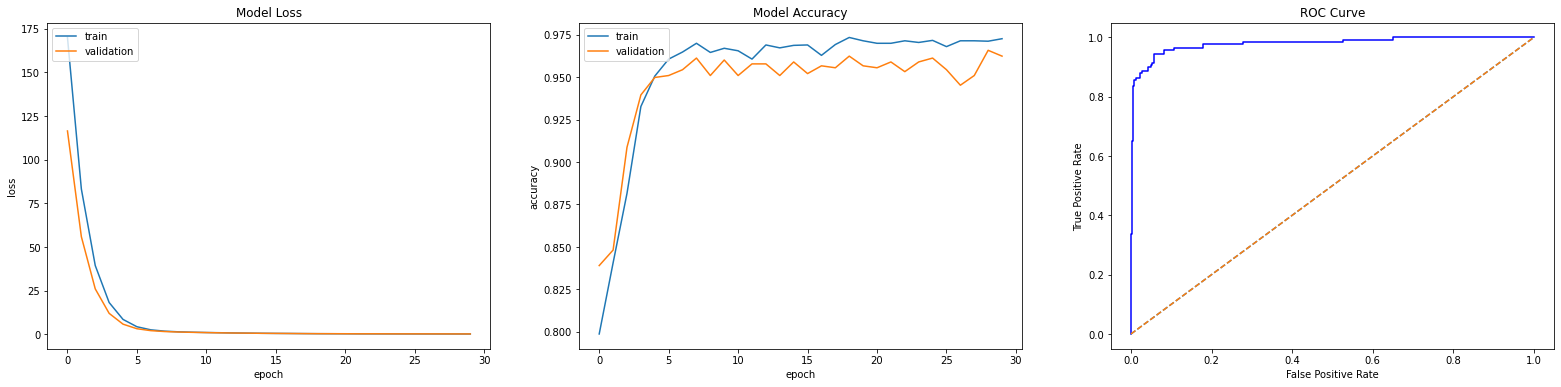

In [95]:
# Model Evaluation
gd30x50_result = pd.DataFrame(gd30x50_fit.history)

# Accuracy Score
gd30x50_trproba = gd30x50_go.predict(X_train_vec_30x50).ravel()
gd30x50_trpred = (gd30x50_trproba > 0.5) * 1
gd30x50_tracc = accuracy_score(y_train, gd30x50_trpred)

gd30x50_tvproba = gd30x50_go.predict(X_val_vec_30x50).ravel()
gd30x50_tvpred = (gd30x50_tvproba > 0.5) * 1
gd30x50_tvacc = accuracy_score(y_val, gd30x50_tvpred)

gd30x50_tsproba = gd30x50_go.predict(X_test_vec_30x50).ravel()
gd30x50_tspred = (gd30x50_tsproba > 0.5) * 1
gd30x50_tsacc = accuracy_score(y_test, gd30x50_tspred)

# Classification Report & Confusion Matrix
gd30x50_clr = classification_report(y_test, gd30x50_tspred)
gd30x50_cfm = confusion_matrix(y_test, gd30x50_tspred)

# F1 Score & AUC Score
gd30x50_f1 = f1_score(y_test, gd30x50_tspred)
gd30x50_auc = roc_auc_score(y_test, gd30x50_tsproba)
gd30x50_fpr, gd30x50_tpr, _ = roc_curve(y_test, gd30x50_tsproba)

# Displaying final model evaluation
print('GloVe Word Embeddings - Dense Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(gd30x50_clr)
print(gd30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(gd30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(gd30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(gd30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(gd30x50_f1))
print('AUC Score                 : {:.03f}'.format(gd30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(gd30x50_result['loss'])
plt.plot(gd30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(gd30x50_result['accuracy'])
plt.plot(gd30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(gd30x50_fpr,gd30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## ii. CNN Text Classifier (GloVE)

### ii.1 Model Architecture

In [96]:
# Initilization
glove_emb_shape = X_train_vec_30x50[0].shape # Word Embeddings shape per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.0002)
modelname       = 'GloVe_CNN_30x50'

# Define Model
def glove_CNN_30x50():
    ipt = Input(shape=glove_emb_shape)
    x = Conv1D(48, 3, padding='same', activation='relu')(ipt)
    x = MaxPool1D(2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.25)(x)
    x = Conv1D(96, 3, activation='relu')(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.15))(x)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
gCNN30x50     = glove_CNN_30x50()
gCNN30x50_go  = glove_CNN_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                    

# Model Setup Summary
gCNN30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "GloVe_CNN_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 30, 50)]          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 30, 48)            7248      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 15, 48)            0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 15, 48)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 15, 64)            9280      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 64)         

### ii.2 Train Model

In [97]:
# Train Model
num_epoch = 40
batchsize = 50

gCNN30x50_fit = gCNN30x50.fit(x=X_train_vec_30x50, y=y_train, validation_data=(X_val_vec_30x50, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
82/82 [==============================] - 1s 9ms/step - loss: 10.2313 - accuracy: 0.8162 - val_loss: 9.2272 - val_accuracy: 0.8390
Epoch 2/40
82/82 [==============================] - 1s 7ms/step - loss: 8.4470 - accuracy: 0.8707 - val_loss: 7.6834 - val_accuracy: 0.9418
Epoch 3/40
82/82 [==============================] - 1s 6ms/step - loss: 7.0433 - accuracy: 0.9297 - val_loss: 6.4369 - val_accuracy: 0.9384
Epoch 4/40
82/82 [==============================] - 1s 7ms/step - loss: 5.8964 - accuracy: 0.9479 - val_loss: 5.3833 - val_accuracy: 0.9555
Epoch 5/40
82/82 [==============================] - 1s 7ms/step - loss: 4.9448 - accuracy: 0.9508 - val_loss: 4.5049 - val_accuracy: 0.9566
Epoch 6/40
82/82 [==============================] - 1s 7ms/step - loss: 4.1414 - accuracy: 0.9581 - val_loss: 3.7723 - val_accuracy: 0.9635
Epoch 7/40
82/82 [==============================] - 1s 7ms/step - loss: 3.4622 - accuracy: 0.9616 - val_loss: 3.1608 - val_accuracy: 0.9612
Epoch 8/40
82/82 [=

### ii.3 Save Model

In [98]:
# Load Trained Model
gCNN30x50_go.load_weights(weightfilepath)
gCNN30x50_go.compile(loss      = loss_func, 
                     optimizer = optmz, 
                     metrics   = ['accuracy'])

# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
gCNN30x50_go.save(modelfilepath)

### ii.4 Model Evaluation

GloVe Word Embeddings - Dense Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       736
           1       0.98      0.89      0.93       140

    accuracy                           0.98       876
   macro avg       0.98      0.94      0.96       876
weighted avg       0.98      0.98      0.98       876

[[734   2]
 [ 16 124]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.992
Validation Data Accuracy  : 0.977
Test Data Accuracy        : 0.979
F1-Score                  : 0.932
AUC Score                 : 0.992


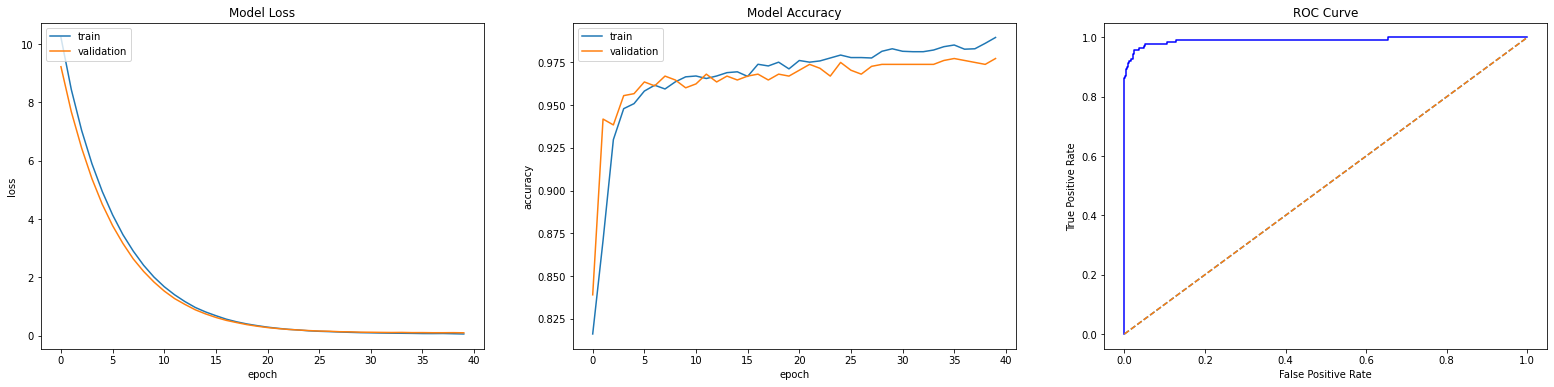

In [99]:
# Model Evaluation
gCNN30x50_result = pd.DataFrame(gCNN30x50_fit.history)

# Accuracy Score & ROC Curve
gCNN30x50_trproba = gCNN30x50_go.predict(X_train_vec_30x50).ravel()
gCNN30x50_trpred = (gCNN30x50_trproba > 0.5) * 1
gCNN30x50_tracc = accuracy_score(y_train, gCNN30x50_trpred)

gCNN30x50_tvproba = gCNN30x50_go.predict(X_val_vec_30x50).ravel()
gCNN30x50_tvpred = (gCNN30x50_tvproba > 0.5) * 1
gCNN30x50_tvacc = accuracy_score(y_val, gCNN30x50_tvpred)

gCNN30x50_tsproba = gCNN30x50_go.predict(X_test_vec_30x50).ravel()
gCNN30x50_tspred = (gCNN30x50_tsproba > 0.5) * 1
gCNN30x50_tsacc = accuracy_score(y_test, gCNN30x50_tspred)

# Classification Report & Confusion Matrix
gCNN30x50_clr = classification_report(y_test, gCNN30x50_tspred)
gCNN30x50_cfm = confusion_matrix(y_test, gCNN30x50_tspred)

# F1 Score & AUC Score
gCNN30x50_f1 = f1_score(y_test, gCNN30x50_tspred)
gCNN30x50_auc = roc_auc_score(y_test, gCNN30x50_tsproba)
gCNN30x50_fpr, gCNN30x50_tpr, _ = roc_curve(y_test, gCNN30x50_tsproba)

# Displaying final model evaluation
print('GloVe Word Embeddings - Dense Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(gCNN30x50_clr)
print(gCNN30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(gCNN30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(gCNN30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(gCNN30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(gCNN30x50_f1))
print('AUC Score                 : {:.03f}'.format(gCNN30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(gCNN30x50_result['loss'])
plt.plot(gCNN30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(gCNN30x50_result['accuracy'])
plt.plot(gCNN30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(gCNN30x50_fpr,gCNN30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## iii. LSTM Text Classifier (GloVE)

### iii.1 Model Architecture

In [100]:
# Initilization
glove_emb_shape = X_train_vec_30x50[0].shape # Word Embeddings shape per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.0001)
modelname       = 'GloVe_LSTM_30x50'

# Define Model
def glove_LSTM_30x50():
    ipt = Input(shape=glove_emb_shape)
    x = LSTM(48, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l2(0.01))(ipt)
    x = LSTM(48, return_sequences=True, dropout=0.2)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(48, activation='relu')(x)
    x = Dense(24, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
gLSTM30x50     = glove_LSTM_30x50()
gLSTM30x50_go  = glove_LSTM_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                    

# Model Setup Summary
gLSTM30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "GloVe_LSTM_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30, 50)]          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 48)            19008     
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 48)            18624     
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 64)            28928     
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_72 (Dense)             (None, 48)                3120      
_________________________________________________________________
dense_73 (Dense)             (None, 24)           

### iii.2 Train Model

In [101]:
# Train Model
num_epoch = 40
batchsize = 30

gLSTM30x50_fit = gLSTM30x50.fit(x=X_train_vec_30x50, y=y_train, validation_data=(X_val_vec_30x50, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
137/137 [==============================] - 6s 19ms/step - loss: 1.2392 - accuracy: 0.8357 - val_loss: 1.0294 - val_accuracy: 0.8390
Epoch 2/40
137/137 [==============================] - 2s 13ms/step - loss: 0.8718 - accuracy: 0.8399 - val_loss: 0.7136 - val_accuracy: 0.8390
Epoch 3/40
137/137 [==============================] - 2s 13ms/step - loss: 0.6433 - accuracy: 0.9165 - val_loss: 0.5706 - val_accuracy: 0.9521
Epoch 4/40
137/137 [==============================] - 2s 13ms/step - loss: 0.5362 - accuracy: 0.9452 - val_loss: 0.4736 - val_accuracy: 0.9578
Epoch 5/40
137/137 [==============================] - 2s 15ms/step - loss: 0.4547 - accuracy: 0.9496 - val_loss: 0.3996 - val_accuracy: 0.9589
Epoch 6/40
137/137 [==============================] - 2s 13ms/step - loss: 0.3850 - accuracy: 0.9552 - val_loss: 0.3492 - val_accuracy: 0.9623
Epoch 7/40
137/137 [==============================] - 2s 13ms/step - loss: 0.3467 - accuracy: 0.9528 - val_loss: 0.3048 - val_accuracy: 0.9635

### iii.3 Save Model

In [102]:
# Load Trained Model
gLSTM30x50_go.load_weights(weightfilepath)
gLSTM30x50_go.compile(loss      = loss_func, 
                      optimizer = optmz, 
                      metrics   = ['accuracy'])

# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
gLSTM30x50_go.save(modelfilepath)

### iii.4 Model Evaluation

GloVe Word Embeddings - LSTM Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       736
           1       0.95      0.88      0.91       140

    accuracy                           0.97       876
   macro avg       0.96      0.93      0.95       876
weighted avg       0.97      0.97      0.97       876

[[729   7]
 [ 17 123]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.976
Validation Data Accuracy  : 0.978
Test Data Accuracy        : 0.973
F1-Score                  : 0.911
AUC Score                 : 0.991


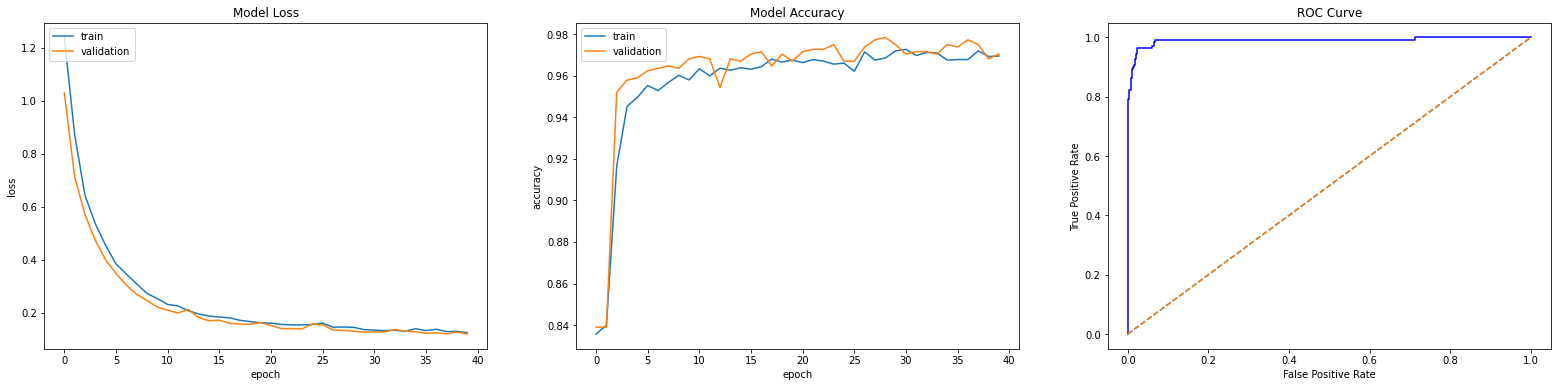

In [103]:
# Model Evaluation
gLSTM30x50_result = pd.DataFrame(gLSTM30x50_fit.history)

# Accuracy Score & ROC Curve
gLSTM30x50_trproba = gLSTM30x50_go.predict(X_train_vec_30x50).ravel()
gLSTM30x50_trpred = (gLSTM30x50_trproba > 0.5) * 1
gLSTM30x50_tracc = accuracy_score(y_train, gLSTM30x50_trpred)

gLSTM30x50_tvproba = gLSTM30x50_go.predict(X_val_vec_30x50).ravel()
gLSTM30x50_tvpred = (gLSTM30x50_tvproba > 0.5) * 1
gLSTM30x50_tvacc = accuracy_score(y_val, gLSTM30x50_tvpred)

gLSTM30x50_tsproba = gLSTM30x50_go.predict(X_test_vec_30x50).ravel()
gLSTM30x50_tspred = (gLSTM30x50_tsproba > 0.5) * 1
gLSTM30x50_tsacc = accuracy_score(y_test, gLSTM30x50_tspred)

# Classification Report & Confusion Matrix
gLSTM30x50_clr = classification_report(y_test, gLSTM30x50_tspred)
gLSTM30x50_cfm = confusion_matrix(y_test, gLSTM30x50_tspred)

# F1 Score & AUC Score
gLSTM30x50_f1 = f1_score(y_test, gLSTM30x50_tspred)
gLSTM30x50_auc = roc_auc_score(y_test, gLSTM30x50_tsproba)
gLSTM30x50_fpr, gLSTM30x50_tpr, _ = roc_curve(y_test, gLSTM30x50_tsproba)

# Displaying final model evaluation
print('GloVe Word Embeddings - LSTM Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(gLSTM30x50_clr)
print(gLSTM30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(gLSTM30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(gLSTM30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(gLSTM30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(gLSTM30x50_f1))
print('AUC Score                 : {:.03f}'.format(gLSTM30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(gLSTM30x50_result['loss'])
plt.plot(gLSTM30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(gLSTM30x50_result['accuracy'])
plt.plot(gLSTM30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(gLSTM30x50_fpr,gLSTM30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## iv. CNN-LSTM Text Classifier (GloVE)

### iv.1 Model Architecture

In [104]:
# Initilization
glove_emb_shape = X_train_vec_30x50[0].shape # Word Embeddings shape per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.0001)
modelname       = 'GloVe_CNNLSTM_30x50'

# Define Model
def glove_CNNLSTM_30x50():
    ipt = Input(shape=glove_emb_shape)
    x = Conv1D(48, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(ipt)
    x = MaxPool1D(2)(x)
    x = Dropout(0.25)(x)
    x = Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    x = MaxPool1D(2)(x)
    # x = Dropout(0.2)(x)
    # x = Conv1D(64, 3, padding='same', activation='relu')(x)
    # x = MaxPool1D(2)(x)
    x = LSTM(64, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l2(0.05))(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    # x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
gCNNLSTM30x50     = glove_CNNLSTM_30x50()
gCNNLSTM30x50_go  = glove_CNNLSTM_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                    

# Model Setup Summary
gCNNLSTM30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "GloVe_CNNLSTM_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 30, 50)]          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 30, 48)            7248      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 15, 48)            0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 15, 48)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 15, 64)            9280      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 7, 64)     

### iv.2 Train Model

In [105]:
# Train Model
num_epoch = 40
batchsize = 10

gCNNLSTM30x50_fit = gCNNLSTM30x50.fit(x=X_train_vec_30x50, y=y_train, validation_data=(X_val_vec_30x50, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
409/409 [==============================] - 8s 14ms/step - loss: 6.9308 - accuracy: 0.8397 - val_loss: 4.5173 - val_accuracy: 0.8390
Epoch 2/40
409/409 [==============================] - 5s 11ms/step - loss: 3.0758 - accuracy: 0.8903 - val_loss: 2.0135 - val_accuracy: 0.9566
Epoch 3/40
409/409 [==============================] - 5s 11ms/step - loss: 1.5015 - accuracy: 0.9427 - val_loss: 1.0881 - val_accuracy: 0.9498
Epoch 4/40
409/409 [==============================] - 4s 11ms/step - loss: 0.8710 - accuracy: 0.9535 - val_loss: 0.6950 - val_accuracy: 0.9623
Epoch 5/40
409/409 [==============================] - 4s 11ms/step - loss: 0.5957 - accuracy: 0.9557 - val_loss: 0.4905 - val_accuracy: 0.9669
Epoch 6/40
409/409 [==============================] - 4s 10ms/step - loss: 0.4476 - accuracy: 0.9594 - val_loss: 0.3904 - val_accuracy: 0.9600
Epoch 7/40
409/409 [==============================] - 4s 11ms/step - loss: 0.3654 - accuracy: 0.9581 - val_loss: 0.3222 - val_accuracy: 0.9669

### iv.3 Save Model

In [106]:
# Load Trained Model
gCNNLSTM30x50_go.load_weights(weightfilepath)
gCNNLSTM30x50_go.compile(loss      = loss_func, 
                      optimizer = optmz, 
                      metrics   = ['accuracy'])

# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
gCNNLSTM30x50_go.save(modelfilepath)

### iv.4 Model Evaluation

GloVe Word Embeddings - Dense Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       736
           1       0.92      0.93      0.92       140

    accuracy                           0.97       876
   macro avg       0.95      0.96      0.95       876
weighted avg       0.98      0.97      0.97       876

[[724  12]
 [ 10 130]]
---------------------------------------------------------
Evaluation Results:
----------------------------------------------
Train Data Accuracy       : 0.998
Validation Data Accuracy  : 0.977
Test Data Accuracy        : 0.975
F1-Score                  : 0.922
AUC Score                 : 0.992


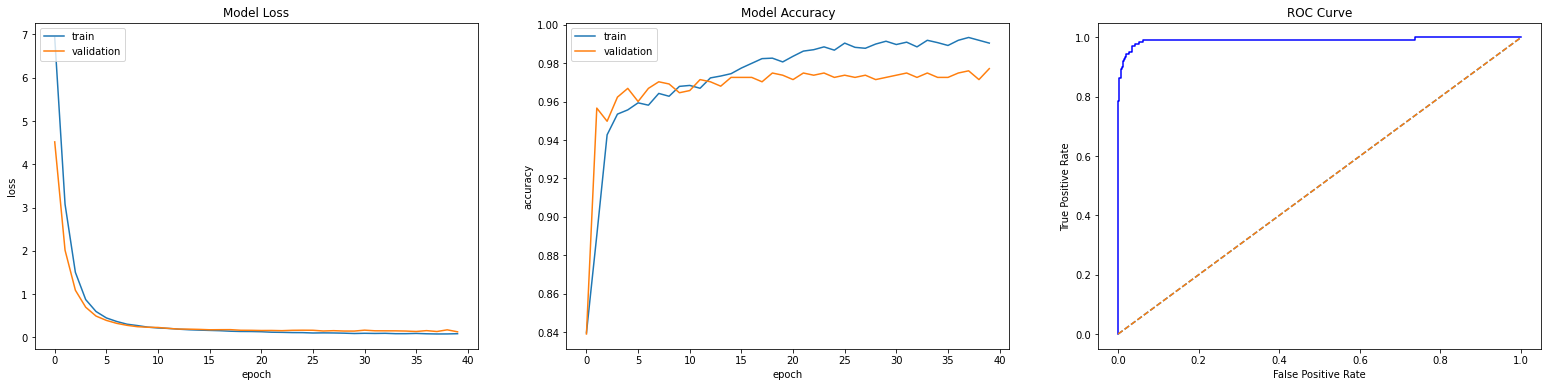

In [107]:
# Model Evaluation
gCNNLSTM30x50_result = pd.DataFrame(gCNNLSTM30x50_fit.history)

# Accuracy Score & ROC Curve
gCNNLSTM30x50_trproba = gCNNLSTM30x50_go.predict(X_train_vec_30x50).ravel()
gCNNLSTM30x50_trpred = (gCNNLSTM30x50_trproba > 0.5) * 1
gCNNLSTM30x50_tracc = accuracy_score(y_train, gCNNLSTM30x50_trpred)

gCNNLSTM30x50_tvproba = gCNNLSTM30x50_go.predict(X_val_vec_30x50).ravel()
gCNNLSTM30x50_tvpred = (gCNNLSTM30x50_tvproba > 0.5) * 1
gCNNLSTM30x50_tvacc = accuracy_score(y_val, gCNNLSTM30x50_tvpred)

gCNNLSTM30x50_tsproba = gCNNLSTM30x50_go.predict(X_test_vec_30x50).ravel()
gCNNLSTM30x50_tspred = (gCNNLSTM30x50_tsproba > 0.5) * 1
gCNNLSTM30x50_tsacc = accuracy_score(y_test, gCNNLSTM30x50_tspred)

# Classification Report & Confusion Matrix
gCNNLSTM30x50_clr = classification_report(y_test, gCNNLSTM30x50_tspred)
gCNNLSTM30x50_cfm = confusion_matrix(y_test, gCNNLSTM30x50_tspred)

# F1 Score & AUC Score
gCNNLSTM30x50_f1 = f1_score(y_test, gCNNLSTM30x50_tspred)
gCNNLSTM30x50_auc = roc_auc_score(y_test, gCNNLSTM30x50_tsproba)
gCNNLSTM30x50_fpr, gCNNLSTM30x50_tpr, _ = roc_curve(y_test, gCNNLSTM30x50_tsproba)

# Displaying final model evaluation
print('GloVe Word Embeddings - Dense Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(gCNNLSTM30x50_clr)
print(gCNNLSTM30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('----------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(gCNNLSTM30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(gCNNLSTM30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(gCNNLSTM30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(gCNNLSTM30x50_f1))
print('AUC Score                 : {:.03f}'.format(gCNNLSTM30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(gCNNLSTM30x50_result['loss'])
plt.plot(gCNNLSTM30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(gCNNLSTM30x50_result['accuracy'])
plt.plot(gCNNLSTM30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(gCNNLSTM30x50_fpr,gCNNLSTM30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# 3. Networks Using Trained Word Embeddings from Dataset

## i. Dense Classifier (Self-Trained)

### i.1 Model Architecture

In [108]:
# Initilization
train_idx_shape = X_train_30idx[0].shape # Dimension of Word Sequencing Index Vectors per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.0002)
modelname       = 'EmbTrain_Dense_30x30'
vocab_size      = tk_size
emb_dim         = 30

# Define Model
def etrain_dense_30x30():
    ipt = Input(shape=train_idx_shape)
    x = Embedding(vocab_size, output_dim=emb_dim)(ipt)
    x = Flatten()(x)
    # x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    # x = Dropout(0.2)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dropout(0.4)(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
ed30x30     = etrain_dense_30x30()
ed30x30_go  = etrain_dense_30x30() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     

# Model Setup Summary
ed30x30.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "EmbTrain_Dense_30x30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 30, 30)            191670    
_________________________________________________________________
flatten_12 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               461312    
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)      

### i.2 Train Model

In [109]:
# Train Model
num_epoch = 30
batchsize = 50

ed30x30_fit = ed30x30.fit(x=X_train_30idx, y=y_train, validation_data=(X_val_30idx, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/30
82/82 [==============================] - 1s 8ms/step - loss: 45.8465 - accuracy: 0.8353 - val_loss: 29.5704 - val_accuracy: 0.8390
Epoch 2/30
82/82 [==============================] - 1s 6ms/step - loss: 20.1139 - accuracy: 0.8399 - val_loss: 12.5612 - val_accuracy: 0.8390
Epoch 3/30
82/82 [==============================] - 1s 6ms/step - loss: 8.3251 - accuracy: 0.8428 - val_loss: 5.0099 - val_accuracy: 0.9053
Epoch 4/30
82/82 [==============================] - 0s 6ms/step - loss: 3.2523 - accuracy: 0.9018 - val_loss: 1.9106 - val_accuracy: 0.9429
Epoch 5/30
82/82 [==============================] - 1s 6ms/step - loss: 1.2255 - accuracy: 0.9621 - val_loss: 0.7185 - val_accuracy: 0.9726
Epoch 6/30
82/82 [==============================] - 1s 6ms/step - loss: 0.4589 - accuracy: 0.9807 - val_loss: 0.2848 - val_accuracy: 0.9749
Epoch 7/30
82/82 [==============================] - 0s 6ms/step - loss: 0.1918 - accuracy: 0.9860 - val_loss: 0.1533 - val_accuracy: 0.9760
Epoch 8/30
82/82

### i.3 Save Model

In [110]:
# Load Weights of Trained Model
ed30x30_go.load_weights(weightfilepath)
ed30x30_go.compile(loss      = loss_func, 
                       optimizer = optmz, 
                       metrics   = ['accuracy'])


# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
ed30x30_go.save(modelfilepath)

### i.4 Model Evaluation

Self-Trained Word Embeddings - Dense Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       736
           1       0.95      0.91      0.93       140

    accuracy                           0.98       876
   macro avg       0.97      0.95      0.96       876
weighted avg       0.98      0.98      0.98       876

[[729   7]
 [ 12 128]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.999
Validation Data Accuracy  : 0.984
Test Data Accuracy        : 0.978
F1-Score                  : 0.931
AUC Score                 : 0.991


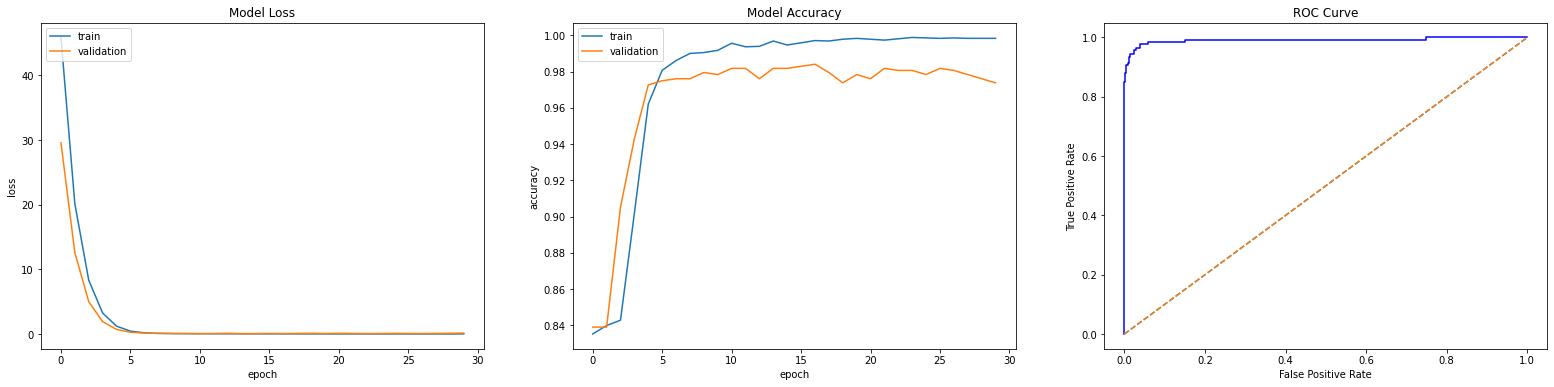

In [111]:
# Model Evaluation
ed30x30_result = pd.DataFrame(ed30x30_fit.history)

# Accuracy Score
ed30x30_trproba = ed30x30_go.predict(X_train_30idx).ravel()
ed30x30_trpred = (ed30x30_trproba > 0.5) * 1
ed30x30_tracc = accuracy_score(y_train, ed30x30_trpred)

ed30x30_tvproba = ed30x30_go.predict(X_val_30idx).ravel()
ed30x30_tvpred = (ed30x30_tvproba > 0.5) * 1
ed30x30_tvacc = accuracy_score(y_val, ed30x30_tvpred)

ed30x30_tsproba = ed30x30_go.predict(X_test_30idx).ravel()
ed30x30_tspred = (ed30x30_tsproba > 0.5) * 1
ed30x30_tsacc = accuracy_score(y_test, ed30x30_tspred)

# Classification Report & Confusion Matrix
ed30x30_clr = classification_report(y_test, ed30x30_tspred)
ed30x30_cfm = confusion_matrix(y_test, ed30x30_tspred)

# F1 Score & AUC Score
ed30x30_f1 = f1_score(y_test, ed30x30_tspred)
ed30x30_auc = roc_auc_score(y_test, ed30x30_tsproba)
ed30x30_fpr, ed30x30_tpr, _ = roc_curve(y_test, ed30x30_tsproba)

# Displaying final model evaluation
print('Self-Trained Word Embeddings - Dense Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(ed30x30_clr)
print(ed30x30_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(ed30x30_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(ed30x30_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(ed30x30_tsacc))
print('F1-Score                  : {:.03f}'.format(ed30x30_f1))
print('AUC Score                 : {:.03f}'.format(ed30x30_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(ed30x30_result['loss'])
plt.plot(ed30x30_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(ed30x30_result['accuracy'])
plt.plot(ed30x30_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(ed30x30_fpr,ed30x30_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## ii. CNN Text Classifier (Self-Trained)

### ii.1 Model Architecture

In [112]:
### Initilization
train_idx_shape = X_train_30idx[0].shape # Dimension of Word Sequencing Index Vectors per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.00015)
modelname       = 'EmbTrain_CNN_30x50'
vocab_size      = tk_size
emb_dim         = 50

# Define Model
def etrain_CNN_30x50():
    ipt = Input(shape=train_idx_shape)
    x = Embedding(vocab_size, output_dim=emb_dim)(ipt)
    x = Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.25)(x)
    x = Conv1D(48, 3, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.25)(x)
    x = Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)
    x = Dense(96, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.15))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
eCNN30x50     = etrain_CNN_30x50()
eCNN30x50_go  = etrain_CNN_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    


# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                

# Model Setup Summary
eCNN30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "EmbTrain_CNN_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 30, 50)            319450    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 28, 32)            4832      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 12, 48)            4656      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 6, 48)      

### ii.2 Train Model

In [113]:
# Train Model
num_epoch = 40
batchsize = 10

eCNN30x50_fit = eCNN30x50.fit(x=X_train_30idx, y=y_train, validation_data=(X_val_30idx, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
409/409 [==============================] - 4s 9ms/step - loss: 8.8311 - accuracy: 0.8387 - val_loss: 5.6707 - val_accuracy: 0.8390
Epoch 2/40
409/409 [==============================] - 4s 9ms/step - loss: 3.9341 - accuracy: 0.8472 - val_loss: 2.6383 - val_accuracy: 0.8710
Epoch 3/40
409/409 [==============================] - 4s 9ms/step - loss: 1.8953 - accuracy: 0.9290 - val_loss: 1.3330 - val_accuracy: 0.9326
Epoch 4/40
409/409 [==============================] - 4s 9ms/step - loss: 0.9868 - accuracy: 0.9670 - val_loss: 0.7293 - val_accuracy: 0.9715
Epoch 5/40
409/409 [==============================] - 4s 9ms/step - loss: 0.5686 - accuracy: 0.9763 - val_loss: 0.4605 - val_accuracy: 0.9669
Epoch 6/40
409/409 [==============================] - 4s 9ms/step - loss: 0.3657 - accuracy: 0.9834 - val_loss: 0.3254 - val_accuracy: 0.9749
Epoch 7/40
409/409 [==============================] - 4s 10ms/step - loss: 0.2697 - accuracy: 0.9848 - val_loss: 0.2602 - val_accuracy: 0.9749
Epoch

### ii.3 Save Model

In [114]:
# Load Weights of Trained Model
eCNN30x50_go.load_weights(weightfilepath)
eCNN30x50_go.compile(loss      = loss_func, 
                       optimizer = optmz, 
                       metrics   = ['accuracy'])



# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
eCNN30x50_go.save(modelfilepath)

### ii.4 Model Evaluation

Self-Trained Word Embeddings - CNN Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       736
           1       0.94      0.95      0.95       140

    accuracy                           0.98       876
   macro avg       0.97      0.97      0.97       876
weighted avg       0.98      0.98      0.98       876

[[728   8]
 [  7 133]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.996
Validation Data Accuracy  : 0.987
Test Data Accuracy        : 0.983
F1-Score                  : 0.947
AUC Score                 : 0.992


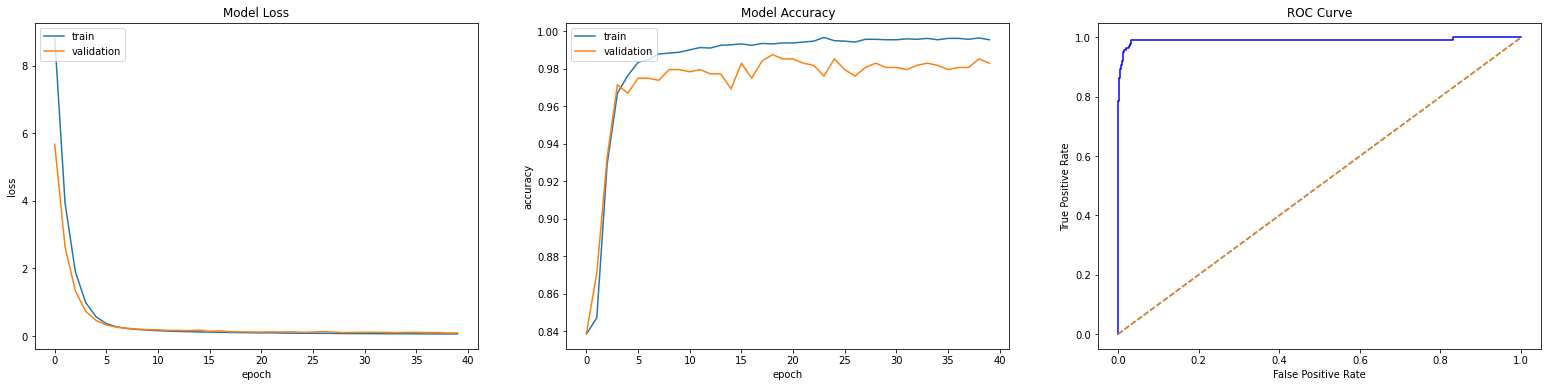

In [115]:
# Model Evaluation
eCNN30x50_result = pd.DataFrame(eCNN30x50_fit.history)

# Accuracy Score
eCNN30x50_trproba = eCNN30x50_go.predict(X_train_30idx).ravel()
eCNN30x50_trpred = (eCNN30x50_trproba > 0.5) * 1
eCNN30x50_tracc = accuracy_score(y_train, eCNN30x50_trpred)

eCNN30x50_tvproba = eCNN30x50_go.predict(X_val_30idx).ravel()
eCNN30x50_tvpred = (eCNN30x50_tvproba > 0.5) * 1
eCNN30x50_tvacc = accuracy_score(y_val, eCNN30x50_tvpred)


eCNN30x50_tsproba = eCNN30x50_go.predict(X_test_30idx).ravel()
eCNN30x50_tspred = (eCNN30x50_tsproba > 0.5) * 1
eCNN30x50_tsacc = accuracy_score(y_test, eCNN30x50_tspred)

# Classification Report & Confusion Matrix
eCNN30x50_clr = classification_report(y_test, eCNN30x50_tspred)
eCNN30x50_cfm = confusion_matrix(y_test, eCNN30x50_tspred)

# F1 Score & AUC Score
eCNN30x50_f1 = f1_score(y_test, eCNN30x50_tspred)
eCNN30x50_auc = roc_auc_score(y_test, eCNN30x50_tsproba)
eCNN30x50_fpr, eCNN30x50_tpr, _ = roc_curve(y_test, eCNN30x50_tsproba)

# Displaying final model evaluation
print('Self-Trained Word Embeddings - CNN Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(eCNN30x50_clr)
print(eCNN30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(eCNN30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(eCNN30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(eCNN30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(eCNN30x50_f1))
print('AUC Score                 : {:.03f}'.format(eCNN30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(eCNN30x50_result['loss'])
plt.plot(eCNN30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(eCNN30x50_result['accuracy'])
plt.plot(eCNN30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(eCNN30x50_fpr,eCNN30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## iii. LSTM Text Classifier (Self-Trained)

### iii.1 Model Architecture

In [116]:
### Initilization
train_idx_shape = X_train_30idx[0].shape # Dimension of Word Sequencing Index Vectors per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.00004)
modelname       = 'EmbTrain_LSTM_30x50'
vocab_size      = tk_size
emb_dim         = 50

# Define Model
def etrain_LSTM_30x50():
    ipt = Input(shape=train_idx_shape)
    x = Embedding(vocab_size, output_dim=emb_dim)(ipt)
    x = LSTM(48, return_sequences=True, dropout=0.3, kernel_regularizer=regularizers.l2(0.1))(x)
    x = LSTM(48, return_sequences=True, dropout=0.3, kernel_regularizer=regularizers.l2(0.05))(x)
    # x = LSTM(64, return_sequences=True, dropout=0.3, kernel_regularizer=regularizers.l2(0.05))(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, dropout=0.3)(x)
    # x = Dropout(0.3)(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(48, activation='relu')(x)
    x = Dropout(0.3)(x)
    # x = Dense(24, activation='relu')(x)
    x = Dense(24, activation='relu')(x)
    # x = Dense(8, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
eLSTM30x50     = etrain_LSTM_30x50()
eLSTM30x50_go  = etrain_LSTM_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     

# Model Setup Summary
eLSTM30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "EmbTrain_LSTM_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 30, 50)            319450    
_________________________________________________________________
lstm_28 (LSTM)               (None, 30, 48)            19008     
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 48)            18624     
_________________________________________________________________
lstm_30 (LSTM)               (None, 30, 64)            28928     
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_106 (Dense)            (None, 48)        

### iii.2 Train Model

In [117]:
# Train Model
num_epoch = 40
batchsize = 10

eLSTM30x50_fit = eLSTM30x50.fit(x=X_train_30idx, y=y_train, validation_data=(X_val_30idx, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
409/409 [==============================] - 10s 17ms/step - loss: 10.6017 - accuracy: 0.8357 - val_loss: 8.9071 - val_accuracy: 0.8390
Epoch 2/40
409/409 [==============================] - 6s 14ms/step - loss: 7.6096 - accuracy: 0.8974 - val_loss: 6.4409 - val_accuracy: 0.9646
Epoch 3/40
409/409 [==============================] - 6s 14ms/step - loss: 5.4967 - accuracy: 0.9689 - val_loss: 4.6332 - val_accuracy: 0.9737
Epoch 4/40
409/409 [==============================] - 6s 14ms/step - loss: 3.9196 - accuracy: 0.9770 - val_loss: 3.3025 - val_accuracy: 0.9749
Epoch 5/40
409/409 [==============================] - 6s 14ms/step - loss: 2.7744 - accuracy: 0.9792 - val_loss: 2.3480 - val_accuracy: 0.9726
Epoch 6/40
409/409 [==============================] - 6s 14ms/step - loss: 1.9372 - accuracy: 0.9851 - val_loss: 1.6370 - val_accuracy: 0.9749
Epoch 7/40
409/409 [==============================] - 6s 15ms/step - loss: 1.3307 - accuracy: 0.9897 - val_loss: 1.1295 - val_accuracy: 0.97

### iii.3 Save Model

In [118]:
# Load Weights of Trained Model
eLSTM30x50_go.load_weights(weightfilepath)
eLSTM30x50_go.compile(loss      = loss_func, 
                       optimizer = optmz, 
                       metrics   = ['accuracy'])



# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
eLSTM30x50_go.save(modelfilepath)

### iii.4 Model Evaluation

Self-Trained Word Embeddings - LSTM Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       736
           1       0.93      0.90      0.92       140

    accuracy                           0.97       876
   macro avg       0.96      0.94      0.95       876
weighted avg       0.97      0.97      0.97       876

[[727   9]
 [ 14 126]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.996
Validation Data Accuracy  : 0.984
Test Data Accuracy        : 0.974
F1-Score                  : 0.916
AUC Score                 : 0.991


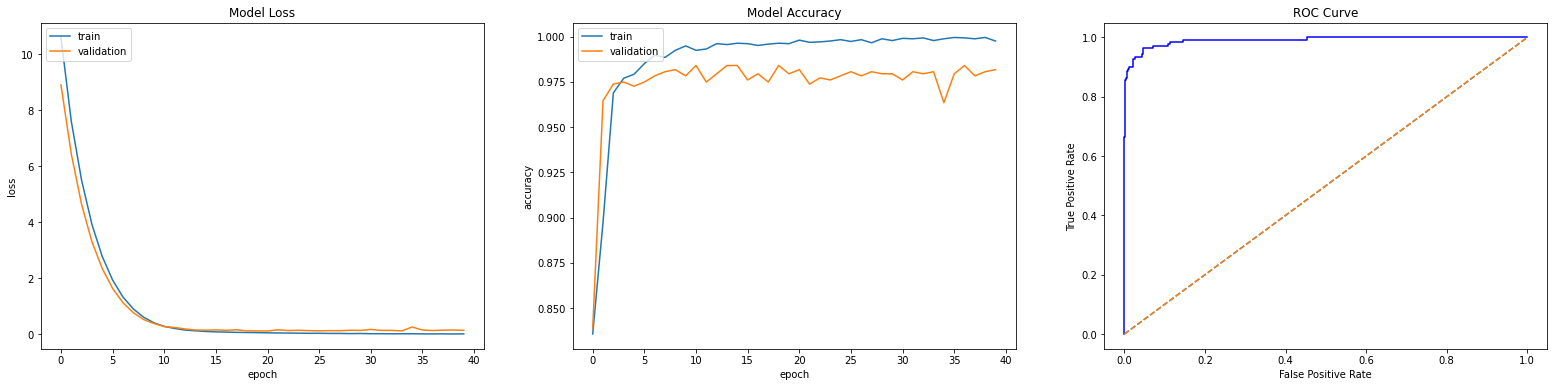

In [119]:
# Model Evaluation
eLSTM30x50_result = pd.DataFrame(eLSTM30x50_fit.history)

# Accuracy Score
eLSTM30x50_trproba = eLSTM30x50_go.predict(X_train_30idx).ravel()
eLSTM30x50_trpred = (eLSTM30x50_trproba > 0.5) * 1
eLSTM30x50_tracc = accuracy_score(y_train, eLSTM30x50_trpred)

eLSTM30x50_tvproba = eLSTM30x50_go.predict(X_val_30idx).ravel()
eLSTM30x50_tvpred = (eLSTM30x50_tvproba > 0.5) * 1
eLSTM30x50_tvacc = accuracy_score(y_val, eLSTM30x50_tvpred)


eLSTM30x50_tsproba = eLSTM30x50_go.predict(X_test_30idx).ravel()
eLSTM30x50_tspred = (eLSTM30x50_tsproba > 0.5) * 1
eLSTM30x50_tsacc = accuracy_score(y_test, eLSTM30x50_tspred)

# Classification Report & Confusion Matrix
eLSTM30x50_clr = classification_report(y_test, eLSTM30x50_tspred)
eLSTM30x50_cfm = confusion_matrix(y_test, eLSTM30x50_tspred)

# F1 Score & AUC Score
eLSTM30x50_f1 = f1_score(y_test, eLSTM30x50_tspred)
eLSTM30x50_auc = roc_auc_score(y_test, eLSTM30x50_tsproba)
eLSTM30x50_fpr, eLSTM30x50_tpr, _ = roc_curve(y_test, eLSTM30x50_tsproba)

# Displaying final model evaluation
print('Self-Trained Word Embeddings - LSTM Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(eLSTM30x50_clr)
print(eLSTM30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(eLSTM30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(eLSTM30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(eLSTM30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(eLSTM30x50_f1))
print('AUC Score                 : {:.03f}'.format(eLSTM30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(eLSTM30x50_result['loss'])
plt.plot(eLSTM30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(eLSTM30x50_result['accuracy'])
plt.plot(eLSTM30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(eLSTM30x50_fpr,eLSTM30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## iv. CNN-LSTM Text Classifier (Self-Trained)

### iv.1 Model Architecture

In [132]:
### Initilization
train_idx_shape = X_train_30idx[0].shape # Dimension of Word Sequencing Index Vectors per sms
loss_func       = 'binary_crossentropy'
optmz           = optimizers.Adam(learning_rate=0.00004)
modelname       = 'EmbTrain_CNNLSTM_30x50'
vocab_size      = tk_size
emb_dim         = 50

# Define Model
def etrain_CNNLSTM_30x50():
    ipt = Input(shape=train_idx_shape)
    x = Embedding(vocab_size, output_dim=emb_dim)(ipt)
    x = Conv1D(48, 3, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.3)(x)
    # x = Conv1D(64, 3, activation='relu')(x)
    # x = MaxPool1D(2)(x)
    # x = LSTM(48, return_sequences=True)(x)
    x = LSTM(48, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l2(0.05))(x)
    x = LSTM(48, return_sequences=True)(x)
    x = LSTM(64)(x)
    # x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=ipt, outputs=x, name=modelname)
    
    model.compile(loss      = loss_func,
                  optimizer = optmz,
                  metrics   = ['accuracy'])
    
    return model

# Setup Model
eCNNLSTM30x50     = etrain_CNNLSTM_30x50()
eCNNLSTM30x50_go  = etrain_CNNLSTM_30x50() # For loading best model & predictions

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     

# Model Setup Summary
eCNNLSTM30x50.summary()
print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

Model: "EmbTrain_CNNLSTM_30x50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_129 (InputLayer)       [(None, 30)]              0         
_________________________________________________________________
embedding_120 (Embedding)    (None, 30, 50)            319450    
_________________________________________________________________
conv1d_292 (Conv1D)          (None, 28, 48)            7248      
_________________________________________________________________
max_pooling1d_292 (MaxPoolin (None, 14, 48)            0         
_________________________________________________________________
dropout_308 (Dropout)        (None, 14, 48)            0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 12, 64)            9280      
_________________________________________________________________
max_pooling1d_293 (MaxPoolin (None, 6, 64)  

### iv.2 Train Model

In [133]:
# Train Model
num_epoch = 40
batchsize = 10

eCNNLSTM30x50_fit = eCNNLSTM30x50.fit(x=X_train_30idx, y=y_train, validation_data=(X_val_30idx, y_val), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)

Epoch 1/40
409/409 [==============================] - 10s 13ms/step - loss: 13.4280 - accuracy: 0.8357 - val_loss: 11.1598 - val_accuracy: 0.8390
Epoch 2/40
409/409 [==============================] - 5s 11ms/step - loss: 9.4399 - accuracy: 0.8399 - val_loss: 7.8967 - val_accuracy: 0.8390
Epoch 3/40
409/409 [==============================] - 5s 12ms/step - loss: 6.6381 - accuracy: 0.8399 - val_loss: 5.5104 - val_accuracy: 0.8390
Epoch 4/40
409/409 [==============================] - 5s 12ms/step - loss: 4.5995 - accuracy: 0.8399 - val_loss: 3.7838 - val_accuracy: 0.8390
Epoch 5/40
409/409 [==============================] - 5s 12ms/step - loss: 3.1420 - accuracy: 0.8409 - val_loss: 2.5669 - val_accuracy: 0.8413
Epoch 6/40
409/409 [==============================] - 4s 11ms/step - loss: 2.1186 - accuracy: 0.8612 - val_loss: 1.7222 - val_accuracy: 0.8790
Epoch 7/40
409/409 [==============================] - 5s 12ms/step - loss: 1.4217 - accuracy: 0.9062 - val_loss: 1.1478 - val_accuracy: 0.9

### iv.3 Save Model

In [134]:
# Load Weights of Trained Model
eCNNLSTM30x50_go.load_weights(weightfilepath)
eCNNLSTM30x50_go.compile(loss      = loss_func, 
                       optimizer = optmz, 
                       metrics   = ['accuracy'])



# Save Model Architecture and Weights to File
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"
eCNNLSTM30x50_go.save(modelfilepath)

### iv.4 Model Evaluation

Self-Trained Word Embeddings - LSTM Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       736
           1       0.95      0.94      0.94       140

    accuracy                           0.98       876
   macro avg       0.97      0.96      0.97       876
weighted avg       0.98      0.98      0.98       876

[[729   7]
 [  9 131]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.997
Validation Data Accuracy  : 0.986
Test Data Accuracy        : 0.982
F1-Score                  : 0.942
AUC Score                 : 0.992


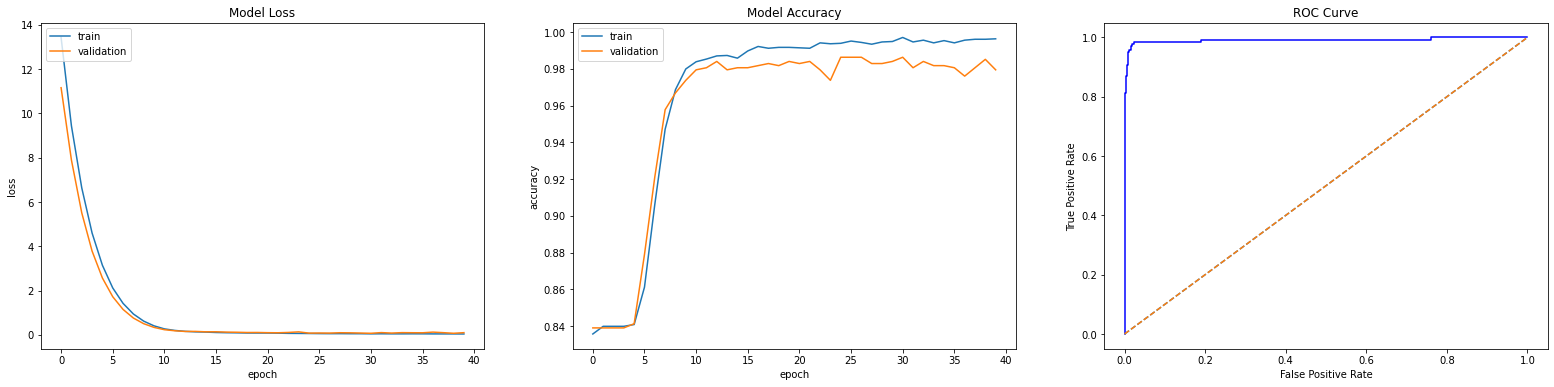

In [135]:
# Model Evaluation
eCNNLSTM30x50_result = pd.DataFrame(eCNNLSTM30x50_fit.history)

# Accuracy Score
eCNNLSTM30x50_trproba = eCNNLSTM30x50_go.predict(X_train_30idx).ravel()
eCNNLSTM30x50_trpred = (eCNNLSTM30x50_trproba > 0.5) * 1
eCNNLSTM30x50_tracc = accuracy_score(y_train, eCNNLSTM30x50_trpred)

eCNNLSTM30x50_tvproba = eCNNLSTM30x50_go.predict(X_val_30idx).ravel()
eCNNLSTM30x50_tvpred = (eCNNLSTM30x50_tvproba > 0.5) * 1
eCNNLSTM30x50_tvacc = accuracy_score(y_val, eCNNLSTM30x50_tvpred)


eCNNLSTM30x50_tsproba = eCNNLSTM30x50_go.predict(X_test_30idx).ravel()
eCNNLSTM30x50_tspred = (eCNNLSTM30x50_tsproba > 0.5) * 1
eCNNLSTM30x50_tsacc = accuracy_score(y_test, eCNNLSTM30x50_tspred)

# Classification Report & Confusion Matrix
eCNNLSTM30x50_clr = classification_report(y_test, eCNNLSTM30x50_tspred)
eCNNLSTM30x50_cfm = confusion_matrix(y_test, eCNNLSTM30x50_tspred)

# F1 Score & AUC Score
eCNNLSTM30x50_f1 = f1_score(y_test, eCNNLSTM30x50_tspred)
eCNNLSTM30x50_auc = roc_auc_score(y_test, eCNNLSTM30x50_tsproba)
eCNNLSTM30x50_fpr, eCNNLSTM30x50_tpr, _ = roc_curve(y_test, eCNNLSTM30x50_tsproba)

# Displaying final model evaluation
print('Self-Trained Word Embeddings - LSTM Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(eCNNLSTM30x50_clr)
print(eCNNLSTM30x50_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(eCNNLSTM30x50_tracc))
print('Validation Data Accuracy  : {:.03f}'.format(eCNNLSTM30x50_tvacc))
print('Test Data Accuracy        : {:.03f}'.format(eCNNLSTM30x50_tsacc))
print('F1-Score                  : {:.03f}'.format(eCNNLSTM30x50_f1))
print('AUC Score                 : {:.03f}'.format(eCNNLSTM30x50_auc))

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(131)
plt.plot(eCNNLSTM30x50_result['loss'])
plt.plot(eCNNLSTM30x50_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
# Plot Train and Validation Accuracy
plt.subplot(132)
plt.plot(eCNNLSTM30x50_result['accuracy'])
plt.plot(eCNNLSTM30x50_result['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
# Plot of ROC Curve
plt.subplot(133)
plt.plot(eCNNLSTM30x50_fpr,eCNNLSTM30x50_tpr, color='blue')
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# 4. K-Fold Cross Validation for Candidate Models and Model Selection

Based on the model training summary, it seems that models based on self-trained word embeddings performed better than that of GloVe word embeddings. <br>
Hence, we pick the top 2 performing self-trained word embedding models for k-fold cross validation to compare final performance and model selection. <br>
The number of fold used here is 5 and the k-fold procedure is repeated 5 times.

In [124]:
# Concatenate Full Dataset
X_30idx = np.concatenate((X_train_30idx, X_val_30idx, X_test_30idx), axis=0)
y       = np.concatenate((y_train, y_val, y_test), axis=0)

print('Dimension of full dataset is: ' + str(X_30idx.shape))
print('Dimension of full labels is:  ' + str(y.shape))

Dimension of full dataset is: (5837, 30)
Dimension of full labels is:  (5837,)


In [125]:
# Performed the Dataset Split using Repeated Stratified K-fold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)

splits_idx = []
for train_idx, test_idx in rskf.split(X_30idx, y):
    fold_set = (train_idx, test_idx)
    splits_idx.append(fold_set)

print('Total number of train-test split sets: ' + str(len(splits_idx)))

Total number of train-test split sets: 25


## i. CNN Text Classifier (Self-Trained)

In [126]:
# Model Parameters
train_idx_shape = X_30idx[0].shape
loss_func       = 'binary_crossentropy'
modelname       = 'EmbTrain_CNN_30x50_KFold'
vocab_size      = tk_size
emb_dim         = 50
num_epoch       = 40
batchsize       = 10

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     


Path to model: dl_training/weights/EmbTrain_CNN_30x50_KFold.hdf5
Path to log:   dl_training/log/EmbTrain_CNN_30x50_KFold.csv


In [127]:
# Fit and Calculate Evaluation Metrics

eCNN30x50_tracc_kf = []
eCNN30x50_tsacc_kf = []
eCNN30x50_f1_kf = []
eCNN30x50_auc_kf = []

for i in range(len(splits_idx)):
    # Printing Info
    clear_output(wait=True)
    print('Training fold {0:2d} '.format(i+1))
    print('=================================================================')
    print('Model:                           ' + modelname)
    print('Word Embeddings Vocabulary Size: ' + str(vocab_size))
    print('Word Embeddings Dimension:       ' + str(emb_dim))
    print('Number of Epoch:                 ' + str(num_epoch))
    print('Batch Size:                      ' + str(batchsize))
    print('-----------------------------------------------------------------')
    print("Path to model:", weightfilepath)
    print("Path to log:  ", logfilepath)
    print('=================================================================')
    
    # Initialize Dataset Split
    train_idx = splits_idx[i][0]
    test_idx = splits_idx[i][1]
    X_train_kf = X_30idx[train_idx]
    y_train_kf = y[train_idx]
    X_test_kf = X_30idx[test_idx]
    y_test_kf = y[test_idx]

    # Initialize Models
    optmz    = optimizers.Adam(learning_rate=0.00015) # Reinitialize Optimizer 
    model    = etrain_CNN_30x50()
    model_go = etrain_CNN_30x50() # For loading optimal weights
    
    # Model Fit
    model_fit = model.fit(x=X_train_kf, y=y_train_kf, validation_data=(X_test_kf, y_test_kf), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)
    
    # Reload Optimal Weights
    model_go.load_weights(weightfilepath)
    model_go.compile(loss      = loss_func, 
                     optimizer = optmz, 
                     metrics   = ['accuracy'])
    
    # Calculate Evaluation Metrics
    trproba = model_go.predict(X_train_kf).ravel()
    trpred = (trproba > 0.5) * 1
    tracc = accuracy_score(y_train_kf, trpred)

    tsproba = model_go.predict(X_test_kf).ravel()
    tspred = (tsproba > 0.5) * 1
    tsacc = accuracy_score(y_test_kf, tspred)

    f1 = f1_score(y_test_kf, tspred)
    auc = roc_auc_score(y_test_kf, tsproba)
    
    # Append Results
    eCNN30x50_tracc_kf.append(tracc)
    eCNN30x50_tsacc_kf.append(tsacc)
    eCNN30x50_f1_kf.append(f1)
    eCNN30x50_auc_kf.append(auc)

clear_output(wait=True)
print('K-Fold Cross Validation Completed!')
eCNN30x50_tracc_kf_avg = np.array(eCNN30x50_tracc_kf, dtype=np.float).mean()
eCNN30x50_tsacc_kf_avg = np.array(eCNN30x50_tsacc_kf, dtype=np.float).mean()
eCNN30x50_f1_kf_avg = np.array(eCNN30x50_f1_kf, dtype=np.float).mean()
eCNN30x50_auc_kf_avg = np.array(eCNN30x50_auc_kf, dtype=np.float).mean()
print(' ')
print('Total of {0:2d} folds trained and evaluated'.format(len(eCNN30x50_tracc_kf)))
print('=====================================================')
print('Final Scores Metrics:')
print('-----------------------------------------------------')
print('Average Training Score: ' + str(round(eCNN30x50_tracc_kf_avg*100, 2)))
print('Average Testing Score:  ' + str(round(eCNN30x50_tsacc_kf_avg*100, 2)))
print('Average f1 Score:       ' + str(round(eCNN30x50_f1_kf_avg*100, 2)))
print('Average AUC:            ' + str(round(eCNN30x50_auc_kf_avg*100, 2)))
print('-----------------------------------------------------')
    

K-Fold Cross Validation Completed!
 
Total of 25 folds trained and evaluated
Final Scores Metrics:
-----------------------------------------------------
Average Training Score: 99.5
Average Testing Score:  99.39
Average f1 Score:       98.06
Average AUC:            99.81
-----------------------------------------------------


## ii. CNN-LSTM Text Classifier (Self-Trained)

In [128]:
# Model Parameters
train_idx_shape = X_30idx[0].shape
loss_func       = 'binary_crossentropy'
modelname       = 'EmbTrain_CNNLSTM_30x50_KFold'
vocab_size      = tk_size
emb_dim         = 50
num_epoch       = 40
batchsize       = 10

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'

print("Path to model:", weightfilepath)
print("Path to log:  ", logfilepath)

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]                                     


Path to model: dl_training/weights/EmbTrain_CNNLSTM_30x50_KFold.hdf5
Path to log:   dl_training/log/EmbTrain_CNNLSTM_30x50_KFold.csv


In [129]:
# Fit and Calculate Evaluation Metrics

eCNNLSTM30x50_tracc_kf = []
eCNNLSTM30x50_tsacc_kf = []
eCNNLSTM30x50_f1_kf = []
eCNNLSTM30x50_auc_kf = []

for i in range(len(splits_idx)):
    # Printing Info
    clear_output(wait=True)
    print('Training fold {0:2d} '.format(i+1))
    print('=================================================================')
    print('Model:                           ' + modelname)
    print('Word Embeddings Vocabulary Size: ' + str(vocab_size))
    print('Word Embeddings Dimension:       ' + str(emb_dim))
    print('Number of Epoch:                 ' + str(num_epoch))
    print('Batch Size:                      ' + str(batchsize))
    print('-----------------------------------------------------------------')
    print("Path to model:", weightfilepath)
    print("Path to log:  ", logfilepath)
    print('=================================================================')
    
    # Initialize Dataset Split
    train_idx = splits_idx[i][0]
    test_idx = splits_idx[i][1]
    X_train_kf = X_30idx[train_idx]
    y_train_kf = y[train_idx]
    X_test_kf = X_30idx[test_idx]
    y_test_kf = y[test_idx]

    # Initialize Models
    optmz    = optimizers.Adam(learning_rate=0.00004) # Reinitialize Optimizer 
    model    = etrain_CNNLSTM_30x50()
    model_go = etrain_CNNLSTM_30x50() # For loading optimal weights
    
    # Model Fit
    model_fit = model.fit(x=X_train_kf, y=y_train_kf, validation_data=(X_test_kf, y_test_kf), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)
    
    # Reload Optimal Weights
    model_go.load_weights(weightfilepath)
    model_go.compile(loss      = loss_func, 
                     optimizer = optmz, 
                     metrics   = ['accuracy'])
    
    # Calculate Evaluation Metrics
    trproba = model_go.predict(X_train_kf).ravel()
    trpred = (trproba > 0.5) * 1
    tracc = accuracy_score(y_train_kf, trpred)

    tsproba = model_go.predict(X_test_kf).ravel()
    tspred = (tsproba > 0.5) * 1
    tsacc = accuracy_score(y_test_kf, tspred)

    f1 = f1_score(y_test_kf, tspred)
    auc = roc_auc_score(y_test_kf, tsproba)
    
    # Append Results
    eCNNLSTM30x50_tracc_kf.append(tracc)
    eCNNLSTM30x50_tsacc_kf.append(tsacc)
    eCNNLSTM30x50_f1_kf.append(f1)
    eCNNLSTM30x50_auc_kf.append(auc)

clear_output(wait=True)
print('K-Fold Cross Validation Completed!')
eCNNLSTM30x50_tracc_kf_avg = np.array(eCNNLSTM30x50_tracc_kf, dtype=np.float).mean()
eCNNLSTM30x50_tsacc_kf_avg = np.array(eCNNLSTM30x50_tsacc_kf, dtype=np.float).mean()
eCNNLSTM30x50_f1_kf_avg = np.array(eCNNLSTM30x50_f1_kf, dtype=np.float).mean()
eCNNLSTM30x50_auc_kf_avg = np.array(eCNNLSTM30x50_auc_kf, dtype=np.float).mean()
print(' ')
print('Total of {0:2d} folds trained and evaluated'.format(len(eCNNLSTM30x50_tracc_kf)))
print('=====================================================')
print('Final Scores Metrics:')
print('-----------------------------------------------------')
print('Average Training Score: ' + str(round(eCNNLSTM30x50_tracc_kf_avg*100, 2)))
print('Average Testing Score:  ' + str(round(eCNNLSTM30x50_tsacc_kf_avg*100, 2)))
print('Average f1 Score:       ' + str(round(eCNNLSTM30x50_f1_kf_avg*100, 2)))
print('Average AUC:            ' + str(round(eCNNLSTM30x50_auc_kf_avg*100, 2)))
print('-----------------------------------------------------')
    

K-Fold Cross Validation Completed!
 
Total of 25 folds trained and evaluated
Final Scores Metrics:
-----------------------------------------------------
Average Training Score: 99.54
Average Testing Score:  99.41
Average f1 Score:       98.15
Average AUC:            99.77
-----------------------------------------------------


# 5. Summary of Results

## i. Training Evaluation

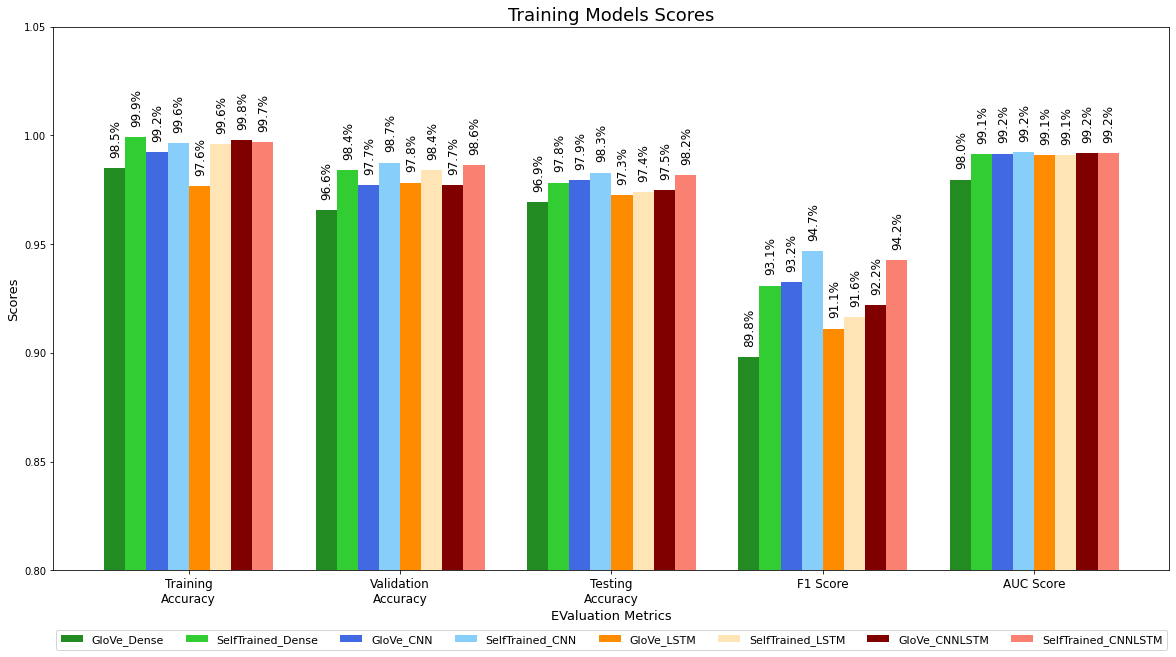

In [138]:
# Compilation Of Model Results

model_labels       = ['GloVe_Dense', 'SelfTrained_Dense', 'GloVe_CNN', 'SelfTrained_CNN', 'GloVe_LSTM', 'SelfTrained_LSTM', 'GloVe_CNNLSTM', 'SelfTrained_CNNLSTM']
eval_labels        = ['Training\nAccuracy', 'Validation\nAccuracy', 'Testing\nAccuracy', 'F1 Score', 'AUC Score']
gd30x50_eval       = [gd30x50_tracc      , gd30x50_tvacc      , gd30x50_tsacc      , gd30x50_f1      , gd30x50_auc]
ed30x30_eval       = [ed30x30_tracc      , ed30x30_tvacc      , ed30x30_tsacc      , ed30x30_f1      , ed30x30_auc]
gCNN30x50_eval     = [gCNN30x50_tracc    , gCNN30x50_tvacc    , gCNN30x50_tsacc    , gCNN30x50_f1    , gCNN30x50_auc]
eCNN30x50_eval     = [eCNN30x50_tracc    , eCNN30x50_tvacc    , eCNN30x50_tsacc    , eCNN30x50_f1    , eCNN30x50_auc]
gLSTM30x50_eval    = [gLSTM30x50_tracc   , gLSTM30x50_tvacc   , gLSTM30x50_tsacc   , gLSTM30x50_f1   , gLSTM30x50_auc]
eLSTM30x50_eval    = [eLSTM30x50_tracc   , eLSTM30x50_tvacc   , eLSTM30x50_tsacc   , eLSTM30x50_f1   , eLSTM30x50_auc]
gCNNLSTM30x50_eval = [gCNNLSTM30x50_tracc, gCNNLSTM30x50_tvacc, gCNNLSTM30x50_tsacc, gCNNLSTM30x50_f1, gCNNLSTM30x50_auc]
eCNNLSTM30x50_eval = [eCNNLSTM30x50_tracc, eCNNLSTM30x50_tvacc, eCNNLSTM30x50_tsacc, eCNNLSTM30x50_f1, eCNNLSTM30x50_auc]

width = 0.1
idx = np.arange(len(eval_labels))

# Plotting horizontal bar chart
plt.figure(figsize=(20,10))
plt.bar(idx-0.35, gd30x50_eval, width, color='forestgreen')
plt.bar(idx-0.25, ed30x30_eval, width, color='limegreen')
plt.bar(idx-0.15, gCNN30x50_eval, width, color='royalblue')
plt.bar(idx-0.05, eCNN30x50_eval, width, color='lightskyblue')
plt.bar(idx+0.05, gLSTM30x50_eval, width, color='darkorange')
plt.bar(idx+0.15, eLSTM30x50_eval, width, color='moccasin')
plt.bar(idx+0.25, gCNNLSTM30x50_eval, width, color='maroon')
plt.bar(idx+0.35, eCNNLSTM30x50_eval, width, color='salmon')

# Score Labels
for i in range(len(eval_labels)):
    plt.text(i-0.345, gd30x50_eval[i]+0.005, str(round(gd30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i-0.245, ed30x30_eval[i]+0.005, str(round(ed30x30_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i-0.145, gCNN30x50_eval[i]+0.005, str(round(gCNN30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i-0.045, eCNN30x50_eval[i]+0.005, str(round(eCNN30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i+0.055, gLSTM30x50_eval[i]+0.005, str(round(gLSTM30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i+0.155, eLSTM30x50_eval[i]+0.005, str(round(eLSTM30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i+0.255, gCNNLSTM30x50_eval[i]+0.005, str(round(gCNNLSTM30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
    plt.text(i+0.355, eCNNLSTM30x50_eval[i]+0.005, str(round(eCNNLSTM30x50_eval[i]*100,1))+'%', ha='center', va='bottom', rotation='vertical', fontsize=12)
plt.legend(model_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=8, prop={'size': 11})
plt.xticks(idx, eval_labels, fontsize=12)
plt.ylim(0.8,1.05)

# for i in np.arange(len(NB_cv_eval)):
#   plt.text(NB_cv_eval[i]+0.04, i+0.15, str(round(NB_cv_eval[i]*100,1))+'%', ha="center", va="bottom", fontsize=12)
#   # plt.text(rf_mfd_eval[i]+0.04, i+0.03, str(round(rf_mfd_eval[i]*100,1))+'%', ha="center", va="bottom", fontsize=12)
#   plt.text(svm_tfidf_eval[i]+0.04, i-0.05, str(round(svm_tfidf_eval[i]*100,1))+'%', ha="center", va="bottom", fontsize=12)
#   plt.text(knn_mfd_eval[i]+0.04, i-0.25, str(round(knn_mfd_eval[i]*100,1))+'%', ha="center", va="bottom", fontsize=12)
# plt.legend(sel_models, loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=6, prop={'size': 11.5})
# plt.yticks(q, sel_metrics, fontsize=12)
# plt.xlim(0,1.1)

# plt.vlines(x=0.91, ymin=-0.4, ymax=1.37, color='orangered', linestyle='--', linewidth=1, alpha=0.5)
# plt.text(0.85,1.4,'Score = 91%', color='orangered', fontsize=12, style='italic')

# plt.vlines(x=0.97, ymin=-0.4, ymax=2.37, color='orangered', linestyle='--', linewidth=1, alpha=0.5)
# plt.text(0.91,2.4,'Score = 97%', color='orangered', fontsize=12, style='italic')

plt.xlabel('EValuation Metrics', fontsize=13)
plt.ylabel('Scores', fontsize=13)
plt.title('Training Models Scores', fontsize=18)

plt.show()


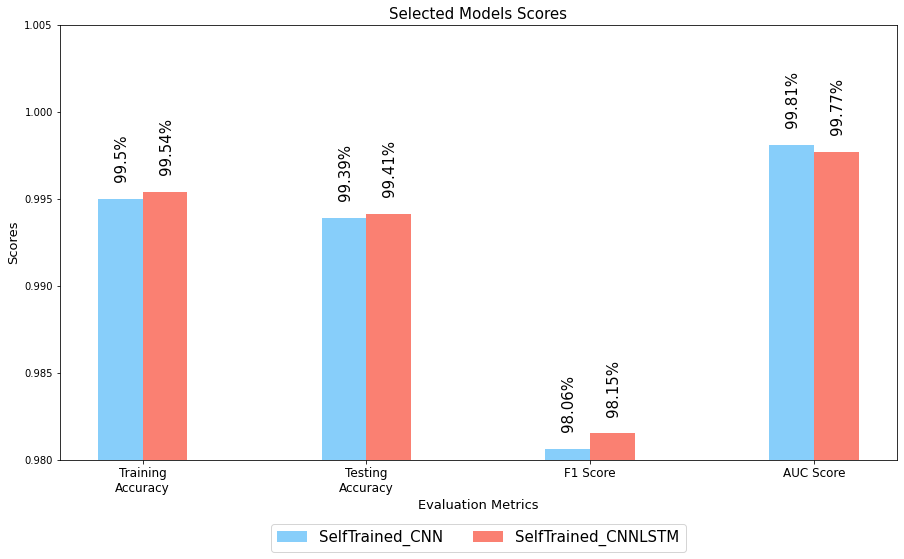

In [13]:
model_sel_labels      = ['SelfTrained_CNN', 'SelfTrained_CNNLSTM']
eval_sel_labels       = ['Training\nAccuracy', 'Testing\nAccuracy', 'F1 Score', 'AUC Score']

eCNN30x50_sel     = [eCNN30x50_tracc_kf_avg, eCNN30x50_tsacc_kf_avg, eCNN30x50_f1_kf_avg, eCNN30x50_auc_kf_avg]
eCNNLSTM30x50_sel = [eCNNLSTM30x50_tracc_kf_avg, eCNNLSTM30x50_tsacc_kf_avg, eCNNLSTM30x50_f1_kf_avg, eCNNLSTM30x50_auc_kf_avg]

width = 0.2
idx = np.arange(len(eval_sel_labels))

plt.figure(figsize=(15,8))
plt.bar(idx-0.1, eCNN30x50_sel, width, color='lightskyblue')
plt.bar(idx+0.1, eCNNLSTM30x50_sel, width, color='salmon')

for i in range(len(eval_sel_labels)):
    plt.text(i-0.095, eCNN30x50_sel[i]+0.001, str(round(eCNN30x50_sel[i]*100,2))+'%', ha='center', va='bottom', rotation='vertical', fontsize=15)
    plt.text(i+0.105, eCNNLSTM30x50_sel[i]+0.001, str(round(eCNNLSTM30x50_sel[i]*100,2))+'%', ha='center', va='bottom', rotation='vertical', fontsize=15)

plt.legend(model_sel_labels, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=6, prop={'size': 15})
plt.xticks(idx, eval_sel_labels, fontsize=12)
plt.ylim(0.98,1.005)

plt.xlabel('Evaluation Metrics', fontsize=13)
plt.ylabel('Scores', fontsize=13)
plt.title('Selected Models Scores', fontsize=15)

plt.show()

## ii. Model Selection

### Setup

In [141]:
# Model Parameters
train_idx_shape = X_30idx[0].shape
loss_func       = 'binary_crossentropy'
modelname       = 'Spam_Clsfr_CNN'
vocab_size      = tk_size
emb_dim         = 50
num_epoch       = 40
batchsize       = 10

# Filepaths for callbacks
weightfolderpath = 'dl_training/weights/'
weightfilepath   = weightfolderpath + modelname + ".hdf5"
logfolderpath   = 'dl_training/log/'
logfilepath     = logfolderpath + modelname + '.csv'
modelfolderpath = 'dl_training/model/'
modelfilepath   = modelfolderpath + modelname + ".hdf5"

# Checkpoint
checkpoint      = ModelCheckpoint(weightfilepath, 
                                  monitor        = 'val_accuracy',
                                  mode           = 'max',
                                  save_best_only = True,
                                  verbose        = 0)
# Training Logger
csv_logger      = CSVLogger(logfilepath)    

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger]    

### Training

In [146]:
# Initialize Dataset Split
# X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_30idx, y, test_size=0.2, stratify=y, random_state=seed)
k = random.randint(0, len(splits_idx))
train_idx = splits_idx[k][0]
test_idx = splits_idx[k][1]
X_train_model = X_30idx[train_idx]
y_train_model = y[train_idx]
X_test_model = X_30idx[test_idx]
y_test_model = y[test_idx]
print(k)

# Initialize Models
optmz         = optimizers.Adam(learning_rate=0.00015)
spam_model    = etrain_CNN_30x50()
spam_model_go = etrain_CNN_30x50() # For loading optimal weights

print('Selected Model - ' + modelname)
print('------------------------------------------------------------------')
print('Path to weight:  ' + weightfilepath)
print('Path to log:     ' + logfilepath)
print('Path to model:   ' + modelfilepath)
print('------------------------------------------------------------------')
spam_model.summary()
print('Training Progress:')
print('==================================================================')

# Model Fit
spam_model_fit = spam_model.fit(x=X_train_model, y=y_train_model, validation_data=(X_test_model, y_test_model), epochs=num_epoch, batch_size=batchsize, shuffle=True, callbacks=callbacks_list)


print('==================================================================')
print('Training Completed!')

# Reload Optimal Weights
spam_model_go.load_weights(weightfilepath)
spam_model_go.compile(loss      = loss_func, 
                      optimizer = optmz, 
                      metrics   = ['accuracy'])

# Save Model
spam_model_go.save(modelfilepath)

print('Model Saved!')

3
Selected Model - Spam_Clsfr_CNN
------------------------------------------------------------------
Path to weight:  dl_training/weights/Spam_Clsfr_CNN.hdf5
Path to log:     dl_training/log/Spam_Clsfr_CNN.csv
Path to model:   dl_training/model/Spam_Clsfr_CNN.hdf5
------------------------------------------------------------------
Model: "Spam_Clsfr_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       [(None, 30)]              0         
_________________________________________________________________
embedding_124 (Embedding)    (None, 30, 50)            319450    
_________________________________________________________________
conv1d_302 (Conv1D)          (None, 28, 32)            4832      
_________________________________________________________________
max_pooling1d_302 (MaxPoolin (None, 14, 32)            0         
__________________________________________________

### Result

In [147]:
# Model Evaluation
spam_model_result = pd.DataFrame(spam_model_fit.history)

# Accuracy Score
spam_model_trproba = spam_model_go.predict(X_train_model).ravel()
spam_model_trpred = (spam_model_trproba > 0.5) * 1
spam_model_tracc = accuracy_score(y_train_model, spam_model_trpred)

spam_model_tsproba = spam_model_go.predict(X_test_model).ravel()
spam_model_tspred = (spam_model_tsproba > 0.5) * 1
spam_model_tsacc = accuracy_score(y_test_model, spam_model_tspred)

# Classification Report & Confusion Matrix
spam_model_clr = classification_report(y_test_model, spam_model_tspred)
spam_model_cfm = confusion_matrix(y_test_model, spam_model_tspred)

# F1 Score & AUC Score
spam_model_f1 = f1_score(y_test_model, spam_model_tspred)
spam_model_auc = roc_auc_score(y_test_model, spam_model_tsproba)
spam_model_fpr, spam_model_tpr, _ = roc_curve(y_test_model, spam_model_tsproba)

# Displaying final model evaluation
print('Self-Trained Word Embeddings - CNN Text Classifier')
print('---------------------------------------------------------')
print('Classification Report: ')
print('---------------------------------------------------------')
print(spam_model_clr)
print(spam_model_cfm)
print('---------------------------------------------------------')
print('Evaluation Results:')
print('---------------------------------------------------------')
print('Train Data Accuracy       : {:.03f}'.format(spam_model_tracc))
print('Test Data Accuracy        : {:.03f}'.format(spam_model_tsacc))
print('F1-Score                  : {:.03f}'.format(spam_model_f1))
print('AUC Score                 : {:.03f}'.format(spam_model_auc))



Self-Trained Word Embeddings - CNN Text Classifier
---------------------------------------------------------
Classification Report: 
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.98      0.95      0.96       187

    accuracy                           0.99      1167
   macro avg       0.99      0.97      0.98      1167
weighted avg       0.99      0.99      0.99      1167

[[977   3]
 [ 10 177]]
---------------------------------------------------------
Evaluation Results:
---------------------------------------------------------
Train Data Accuracy       : 0.998
Test Data Accuracy        : 0.989
F1-Score                  : 0.965
AUC Score                 : 0.992
